In [1]:
import subprocess
import os
print('Current conda environment:', os.environ['CONDA_DEFAULT_ENV'])
os.environ['TOKENIZERS_PARALLELISM'] = "false"

cwd = os.getcwd()
print(cwd)

import warnings
warnings.filterwarnings('ignore')

import random
random.seed(42)

Current conda environment: reinvent
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


In [2]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc = {'figure.figsize':(15,8)})

from crem.crem import grow_mol, mutate_mol
crem_db = '../crem_db/crem_db2.5.db'

import mols2grid

from rdkit import Chem
from rdkit.Chem import AllChem, rdFingerprintGenerator, CanonSmiles, Draw, MolFromSmiles, PandasTools
from rdkit.Chem.rdmolops import RDKFingerprint
from rdkit import DataStructs
from rdkit.DataStructs.cDataStructs import BulkTanimotoSimilarity
import useful_rdkit_utils as uru

import safe as sf
import datamol as dm

import mols2grid

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, roc_auc_score

import torch

from coati.generative.coati_purifications import embed_smiles
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.simple_coati2.io import load_coati2

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality


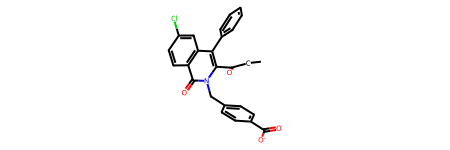

In [3]:
initial_mol = Chem.MolFromMolFile("data/docking/2zdt_ligand.sdf")
initial = Chem.MolToSmiles(initial_mol)

initial_mol

In [4]:
initial

'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)[O-])cc1'

In [5]:
def remove_odd_rings(df):
    ring_system_lookup = uru.RingSystemLookup.default()
    df['ring_systems'] = df.SMILES.apply(ring_system_lookup.process_smiles)
    df[['min_ring','min_freq']] = df.ring_systems.apply(uru.get_min_ring_frequency).to_list()
    df = df.query('min_freq > 100').copy()
    return df.iloc[:, 0:3]

In [6]:
# Change directory to generate analogs with python script
%cd ..

arg1 = '--input_frag'
arg2 = '--remove_odd_rings'
subprocess.run(['python3', 'generate_analogs.py', arg1, initial, arg2, False],
                 stdout=subprocess.DEVNULL,
                 stderr=subprocess.STDOUT)
        
# Change directory back to that of the current notebook
%cd experiments

/home/fts_g_ucla_edu/Projects/rips-relay
/home/fts_g_ucla_edu/Projects/rips-relay/experiments


### REINVENT

In [7]:
df = pd.read_csv('data/dataframe.csv')

df = df.loc[:, ['SMILES']]
df['Model'] = 'reinvent'

In [8]:
df = df.sample(500)

df

,SMILES,Model
908,CSc1c(-c2ccccc2)c2cc(C#N)ccc2c(=O)n1Cc1ccc(C(=...,reinvent
363,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,reinvent
939,CCCSc1c(-c2ccccc2)c2cc(C(=O)O)ccc2c(=O)n1Cc1cc...,reinvent
287,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
987,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
...,...,...
454,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cn(...,reinvent
68,CCC(=O)c1c(-c2ccccc2)c2cc(C)ccc2c(=O)n1Cc1ccc(...,reinvent
226,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
325,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent


### CReM

In [9]:
out_list = []
mutate_list = list(mutate_mol(initial_mol, db_name=crem_db, return_mol=False))

for idx, analog in enumerate(mutate_list):
    out_list.append([analog])

In [10]:
temp_df = pd.DataFrame(out_list, columns=["SMILES"])

temp_df['Model'] = 'crem'

In [11]:
temp_df = temp_df.sample(500)

temp_df

,SMILES,Model
264,CCCOc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)ccc...,crem
100,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
535,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
310,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
221,C=C=CCOc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)...,crem
...,...,...
288,CCNCc1ccc(Cn2c(C(=O)CC)c(-c3ccccc3)c3cc(Cl)ccc...,crem
480,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
599,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem
385,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,crem


In [12]:
df = pd.concat((df, temp_df))

### Coati

In [13]:
encoder2, tokenizer2 = load_coati2(
    freeze=True,
    device=torch.device("cuda:0"),
    doc_url="s3://terray-public/models/coati2_chiral_03-08-24.pkl"
)

Loading model from s3://terray-public/models/coati2_chiral_03-08-24.pkl
Loading tokenizer coati2_12_12 from s3://terray-public/models/coati2_chiral_03-08-24.pkl
number of parameters: 50.44M
number of parameters Total: xformer: 54.81M 
vocab_name not found in tokenizer_vocabs, trying to load from file
Freezing encoder
56385536 params frozen!


In [14]:
def gen_mol(smiles, coati_version=1, num_variations=100, noise_scale=0.15):

    # Embed the SMILES string
    smiles = CanonSmiles(smiles)

    if coati_version == 1:
        vector = embed_smiles(smiles, encoder1, tokenizer1)
    elif coati_version == 2:
        vector = embed_smiles(smiles, encoder2, tokenizer2)

    # Noise is added as an isotropic Gaussian with std=noise_scale
    if coati_version == 1:
        nearby_smiles = encoder1.hclip_to_2d_batch(
            h_clip=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer1,
            noise_scale=noise_scale
        )
    elif coati_version == 2:
        nearby_smiles = encoder2.hcoati_to_2d_batch(
            h_coati=vector.unsqueeze(0).repeat(num_variations, 1),
            tokenizer=tokenizer2,
            noise_scale=noise_scale,
        )

    # Retrieve canonical SMILES of generated analogs
    unique_valid_smiles = list(set([CanonSmiles(smi) for smi in nearby_smiles if MolFromSmiles(smi)]))

    # Store true if original molecule is in the set of generated analogs
    had_orig = smiles in unique_valid_smiles

    unique_valid_smiles = list(set([smiles] + unique_valid_smiles))

    # Generate molecular fingerprints
    fp = RDKFingerprint(MolFromSmiles(smiles), minPath=1, maxPath=7, fpSize=2048)
    fps = [RDKFingerprint(MolFromSmiles(x), minPath=1, maxPath=7, fpSize=2048) for x in unique_valid_smiles]

    # Compute tanimoto similarities between distributions and store as list of strings
    sim = BulkTanimotoSimilarity(fp, fps)
    sim_str = [str(round(x, 2)) for x in sim]

    unique_valid_smiles, sim_str = zip(*sorted(zip(unique_valid_smiles, sim_str), key=lambda x:x[1], reverse=True))

    if not had_orig:
        unique_valid_smiles, sim_str = zip(*[[i, f"{j} (Added)"] if i==smiles else [i, j] for i, j in zip(unique_valid_smiles, sim_str)])

    # Output for molecule generation
    print (f"Attempted {num_variations} COATI{coati_version} generations with a noise scale of {noise_scale} and generated {len(unique_valid_smiles)} unique structures.")
        
    return unique_valid_smiles

In [16]:
coati_smiles = gen_mol(initial, coati_version = 2, num_variations = 1000, noise_scale = 0.5)

Attempted 1000 COATI2 generations with a noise scale of 0.5 and generated 209 unique structures.


In [17]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = coati_smiles
temp_df['Model'] = 'coati'

In [18]:
temp_df

,SMILES,Model
0,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,coati
1,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,coati
2,CCCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc...,coati
3,CC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(...,coati
4,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,coati
...,...,...
204,CCC(=O)C1=C(c2ccccc2)c2cc(Cl)ccc2CCN1C(=O)c1cc...,coati
205,CC[C@@]1(c2ccccc2)c2cc(Cl)ccc2C(=O)N1Cc1ccc(C(...,coati
206,CCC(C(=O)Cn1c(=S)[nH]c2ccc(C(=O)[O-])cc21)=C([...,coati
207,CCC1=C([O-])c2cc(-c3ccccc3)c(Cl)cc2CN1Cc1ccc(C...,coati


In [19]:
df = pd.concat((df, temp_df))

### SAFE

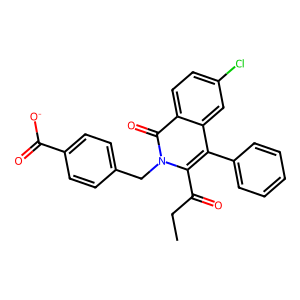

In [20]:
initial_mol = dm.to_mol(initial)
display(dm.to_image(initial_mol))

In [21]:
designer = sf.SAFEDesign.load_default(verbose=True)

designer.model

SAFEDoubleHeadsModel(
  (transformer): GPT2Model(
    (wte): Embedding(1880, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=1880, bias=False)
  (multiple_choice_head): PropertyHead(
    (summary): Linear(in_features=768, out_features=64, bias=True)
    

In [22]:
safe_smiles = designer.de_novo_generation(sanitize=True, n_samples_per_trial=500)

  0%|          | 0/1 [00:00<?, ?it/s]

Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
Failed to patch pandas - PandasTools will have limited functionality
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - Pand

In [23]:
temp_df = pd.DataFrame()
temp_df['SMILES'] = safe_smiles
temp_df['Model'] = 'safe'

In [24]:
df = pd.concat((df, temp_df))

In [25]:
df

,SMILES,Model
908,CSc1c(-c2ccccc2)c2cc(C#N)ccc2c(=O)n1Cc1ccc(C(=...,reinvent
363,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,reinvent
939,CCCSc1c(-c2ccccc2)c2cc(C(=O)O)ccc2c(=O)n1Cc1cc...,reinvent
287,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
987,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cc(...,reinvent
...,...,...
463,C=C(C)Cn1c([C@@H]2CCO[C@H]2C)nnc1N1CCC[C@@H]1C...,safe
464,CN=C(O)CCCN(C)S(=O)(=O)c1ccc(C=NO)cc1,safe
465,CCNC(=O)c1ccc(OCc2ccn(CC)n2)cc1,safe
466,CC(C)(CNC(=S)Nc1ccccc1)c1cc(C(F)(F)F)ccn1,safe


In [3]:
df = pd.read_csv('data/dataframe.csv')

In [4]:
smiles = df['SMILES'].to_list()

In [5]:
smiles

['CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(NS(C)(=O)=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(S(C)(=O)=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cccc(C(=O)O)c1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccccc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(S(N)(=O)=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc(S(C)(=O)=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(OC)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc(C(=O)O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(=O)NC)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C(N)=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(C#N)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccccc1C(=O)O',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cccc(C(N)=O)c1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc(NC(C)=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc(S(N)(=O)=O)cc1',
 'CCC(=O)c1c(-c2ccccc2)c2cc(Br)ccc2c(=O)n1Cc1ccc(NS(C)(=O)=O)cc1

### Evaluating Metrics w/ MolScore

In [6]:
from molscore import MolScore

In [7]:
ms = MolScore(model_name='mol2mol', task_config='molscore/feature_selection.json')
scores = ms.score(smiles)

: 

In [ ]:
# Once finished
metrics = ms.compute_metrics(
    endpoints=None, # Optional list: by default will use the running final score/reward value
    thresholds=None,  # Optional list: if specified will calculate the yield of molecules above that threshold 
    # chemistry_filters_basic=False,  # Optional, bool: Additionally re-calculate metrics after filtering out unreasonable chemistry
    budget=10000,  # Optional, int: Calculate metrics only with molecules within this budget
    n_jobs=1,  # Optional, int: Multiprocessing
    benchmark=None,  # Optional, str: Name of benchmark, this may specify additional metrics to compute
)

### Random Forest Classification

In [ ]:
y = df['Model'].to_numpy()

KeyError: 'Model'

In [4]:
df = pd.read_csv('molscore/2024_07_15_mol2mol_feature_selection/iterations/000001_scores.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'molscore/2024_07_15_mol2mol_feature_selection/iterations/000001_scores.csv'

In [ ]:
df.drop(['Unnamed: 0', 'desc_MolecularFormula'], axis=1, inplace=True)

df

,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,...,desc_FlourineCount,tanimoto_Sim,tanimoto_Cmpd1_Sim,dice_Sim,dice_Cmpd1_Sim,RAScore_pred_proba,raw_valid_score,amean,filter,score_time
0,mol2mol,feature_selection,1,0,3.295359,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1cn(...,True,1,True,0,...,0,0.569444,0.569444,0.725664,0.725664,0.355959,1,1.0,1.0,17.639636
1,mol2mol,feature_selection,1,1,3.295359,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,True,1,True,0,...,0,0.745763,0.745763,0.854369,0.854369,0.863388,1,1.0,1.0,17.639636
2,mol2mol,feature_selection,1,2,3.295359,CCC(=O)c1c(-c2ccccc2)c2cc(Cl)ccc2c(=O)n1Cc1ccc...,True,1,True,0,...,0,0.733333,0.733333,0.846154,0.846154,0.856591,1,1.0,1.0,17.639636
3,mol2mol,feature_selection,1,3,3.295359,CCC(=O)c1c(-c2ccccc2)c2cc(OC)ccc2c(=O)n1Cc1ccc...,True,1,True,0,...,0,0.606061,0.606061,0.754717,0.754717,0.921030,1,1.0,1.0,17.639636
4,mol2mol,feature_selection,1,4,3.295359,CCC(=O)c1c(-c2ccccc2)c2ccccc2c(=O)n1Cc1ccc(C(N...,True,1,True,0,...,0,0.655172,0.655172,0.791667,0.791667,0.963429,1,1.0,1.0,17.639636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,mol2mol,feature_selection,1,1701,3.295359,CC[C@H](CCC(=O)[O-])[NH2+]Cc1cc(OC)c(O)c(OC)c1,True,1,True,0,...,0,0.168831,0.168831,0.288889,0.288889,0.976255,1,1.0,1.0,17.639636
1702,mol2mol,feature_selection,1,1702,3.295359,Cn1cc(C(=O)C[C@@H]2CCCN2C(=O)c2cc(NC(N)=O)cc(N...,True,1,True,0,...,0,0.164835,0.164835,0.283019,0.283019,0.953756,1,1.0,1.0,17.639636
1703,mol2mol,feature_selection,1,1703,3.295359,CC(C)CNC(=O)[C@@H](C)[NH2+][C@H]1CC[C@H](NC(=O...,True,1,True,0,...,0,0.075000,0.075000,0.139535,0.139535,0.987414,1,1.0,1.0,17.639636
1704,mol2mol,feature_selection,1,1704,3.295359,Nc1cncc(-c2cnc3c(c2)c(-c2cc(C4CC4)nc4ccc(C(F)(...,True,1,True,0,...,7,0.094340,0.094340,0.172414,0.172414,0.346057,1,1.0,1.0,17.639636


In [ ]:
X = df.iloc[:, 10:-4]

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')

In [ ]:
y = y.reshape(-1, 1)

In [ ]:
enc.fit_transform(y)

<1706x4 sparse matrix of type '<class 'numpy.float64'>'
	with 1706 stored elements in Compressed Sparse Row format>

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

In [ ]:
len(X_train)

1364

In [ ]:
len(X_test)

342

In [ ]:
rf = RandomForestClassifier(num_estimators=500,
                            class_weight='balanced',
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [ ]:
rf_pred = rf.predict(X_test)

In [ ]:
size = len(y_test)
score = 0

for pred, actual in zip(rf_pred, y_test):

    if pred == actual:
        score += 1 / size

In [ ]:
score

0.9269005847953152

In [ ]:
weights = rf.feature_importances_
vars = X.columns

In [ ]:
d = {'vars': vars, 'weights': weights}

df_scores = pd.DataFrame(data=d)

In [ ]:
df_scores.sort_values(['weights'], ascending=False)

,vars,weights
19,tanimoto_Sim,0.158377
15,desc_FormalCharge,0.115589
22,dice_Cmpd1_Sim,0.107639
21,dice_Sim,0.099523
20,tanimoto_Cmpd1_Sim,0.097219
16,desc_Bertz,0.064972
0,desc_QED,0.058833
2,desc_CLogP,0.048823
3,desc_MolWt,0.040453
4,desc_HeavyAtomCount,0.033658
